In [5]:
!pip install unidecode

In [6]:
#transformation
import numpy as np
import unidecode
from re import sub

#viz (learning curve)
import matplotlib.pyplot as plt
%matplotlib inline

#modélisation
from keras.models import *
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

#génération de texte
import random

#sauvegarde
from keras.callbacks import ModelCheckpoint
import json

In [8]:
#importation du fichier texte avec l'encodage lié, passage en minuscules
raw_text = open("victorhugo.txt", 'r', encoding='utf-8').read().lower() 

raw_text = unidecode.unidecode(raw_text) #suppression des accents
#sub : ca va ciblé le traitement mot par mot
#pattern va chercher toute les valeurs digital et on remplace avec rien
raw_text = sub(pattern=r"\d", repl=r"", string=raw_text) #suppression caractères numériques
#suppression de certains caractères spéciaux (pas tous, sinon utilisation d'une regex)
raw_text = raw_text.replace(">", "")
raw_text = raw_text.replace("<", "")
raw_text = raw_text.replace("!", "")
raw_text = raw_text.replace("?", "")
raw_text = raw_text.replace("-", "")
raw_text = raw_text.replace("$", "")
raw_text = raw_text.replace(";", "")
raw_text = raw_text.replace(":", "")

raw_text = raw_text.strip() #suppression des espaces inutiles
print(raw_text[:1000])

parce que, jargonnant vepres, jeune et vigile,
exploitant dieu qui reve au fond du firmament,
vous avez, au milieu du divin evangile,
ouvert boutique effrontement 

parce que vous feriez prendre a jesus la verge,
cyniques brocanteurs sortis on ne sait d'ou 
parce que vous allez vendant la sainte vierge
dix sous avec miracle, et sans miracle un sou 

parce que vous contez d'effroyables sornettes
qui font des temples saints trembler les vieux piliers 
parce que votre style eblouit les lunettes
des duegnes et des marguilliers 

parce que la soutane est sous vos redingotes,
parce que vous sentez la crasse et non l'oeillet,
parce que vous baclez un journal de bigotes
pense par escobar, ecrit par patouillet 

parce qu'en balayant leurs portes, les concierges
poussent dans le ruisseau ce pamphlet meprise 
parce que vous melez a la cire des cierges
votre affreux suif vertdegrise 

parce qu'a vous tout seuls vous faites une espece
parce qu'enfin, blanchis dehors et noirs dedans,
criant mea culp

###Transformer les données
dict caractère/num et num/caractère
ils nous serviront à encoder/decoder le text d'entrainement et le text généré

In [9]:
print('corpus length:', len(raw_text)) #nombres de caractères dans le texte


corpus length: 125813


In [10]:
chars = sorted(list(set(raw_text))) #liste de caractères uniques
print('total chars:', len(chars)) #nb de caractères uniques
char_indices = dict((c, i) for i, c in enumerate(chars)) #création dictionnaire "caractère : numéro"
indices_char = dict((i, c) for i, c in enumerate(chars)) #création dictionnaire "numéro : caractère"
#enregistrement des dictionnaires créés en local
#dumps = exporté
#w = fichier texte
with open("model_rnn_char_indices", "w") as f:
    f.write(json.dumps(char_indices))
with open("model_rnn_indices_char", "w") as f:
    f.write(json.dumps(indices_char))


total chars: 32


Dans la boucle suivante, nous créons les séquences qui, une fois encodées seront utilisées comme input pour notre modèle


In [11]:
maxlen = 40  #longueur de 40 caractères
step = 3     #step tous les 3 caractères
#sentences = input
#next_chars = output
sentences = []
next_chars = []

#création de la séquence d'entrée et séquence suivante
for i in range(0, len(raw_text) - maxlen, step +1):
    sentences.append(raw_text[i: i + maxlen])
    next_chars.append(raw_text[i + maxlen])

print('nb sequences:', len(sentences))
print(sentences)

nb sequences: 31444
['parce que, jargonnant vepres, jeune et v', 'e que, jargonnant vepres, jeune et vigil', 'e, jargonnant vepres, jeune et vigile,\ne', 'argonnant vepres, jeune et vigile,\nexplo', 'nnant vepres, jeune et vigile,\nexploitan', 't vepres, jeune et vigile,\nexploitant di', 'pres, jeune et vigile,\nexploitant dieu q', ', jeune et vigile,\nexploitant dieu qui r', 'une et vigile,\nexploitant dieu qui reve ', 'et vigile,\nexploitant dieu qui reve au f', 'igile,\nexploitant dieu qui reve au fond ', 'e,\nexploitant dieu qui reve au fond du f', 'xploitant dieu qui reve au fond du firma', 'itant dieu qui reve au fond du firmament', 't dieu qui reve au fond du firmament,\nvo', 'eu qui reve au fond du firmament,\nvous a', 'ui reve au fond du firmament,\nvous avez,', 'eve au fond du firmament,\nvous avez, au ', 'au fond du firmament,\nvous avez, au mili', 'ond du firmament,\nvous avez, au milieu d', 'du firmament,\nvous avez, au milieu du di', 'irmament,\nvous avez, au milieu du di

In [12]:
#vectorisation (one hot encoding)
#zeros = il crée des 0
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence): # chars: list des caractères unique
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [13]:
x.shape

(31444, 40, 32)

In [14]:
y.shape

(31444, 32)

Créer une sauvegarde locale pour conservé les meilleurs poids générés par le RNN.
La sauvegardde se fait uniquement en cas de diminution de score de loss.


In [15]:
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
callbacks_list = [ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')]
#forme d'enregistrement, selon la loss, exprimé par écriture, uniquement lors d'amélioration, "min" = for loss this should be min

Là, c'est une fonction qui permet d'arreter l'entrainement lorsque la loss ne s'est pas améliorée après 100 epochs

In [16]:
early_stop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

In [17]:
# build the model: a single LSTM
model = Sequential()
model.add(LSTM(81, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 81)                36936     
_________________________________________________________________
dense (Dense)                (None, 32)                2624      
Total params: 39,560
Trainable params: 39,560
Non-trainable params: 0
_________________________________________________________________


### Entrainer un RNN à prédire le prochain caractère

In [19]:
model.fit(x, y, batch_size=32, epochs=100, validation_split=0.5, callbacks=[callbacks_list, early_stop])

Epoch 1/100
492/492 [==============================] - 4s 8ms/step - loss: 1.8899 - accuracy: 0.4044 - val_loss: 1.9846 - val_accuracy: 0.3860

Epoch 00001: loss improved from 2.34934 to 1.88995, saving model to weights-improvement-01-1.8899-bigger.hdf5
Epoch 2/100
492/492 [==============================] - 4s 8ms/step - loss: 1.7748 - accuracy: 0.4386 - val_loss: 1.9614 - val_accuracy: 0.4018

Epoch 00002: loss improved from 1.88995 to 1.77482, saving model to weights-improvement-02-1.7748-bigger.hdf5
Epoch 3/100
492/492 [==============================] - 4s 7ms/step - loss: 1.6803 - accuracy: 0.4728 - val_loss: 1.9851 - val_accuracy: 0.4057

Epoch 00003: loss improved from 1.77482 to 1.68032, saving model to weights-improvement-03-1.6803-bigger.hdf5
Epoch 4/100
492/492 [==============================] - 4s 8ms/step - loss: 1.6005 - accuracy: 0.4892 - val_loss: 2.0077 - val_accuracy: 0.3900

Epoch 00004: loss improved from 1.68032 to 1.60051, saving model to weights-improvement-04-1.6

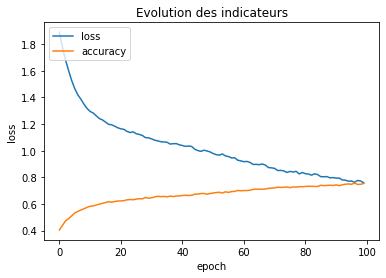

In [20]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['accuracy'])
plt.title('Evolution des indicateurs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

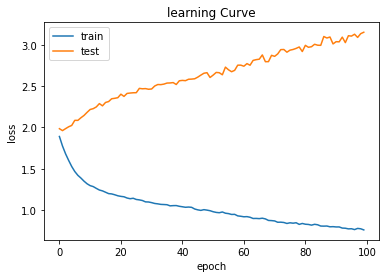

In [21]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('learning Curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# plus proche de 1.0 plus la prediction est bonne 
def sample_index(preds, temperature = 1.0): #On prend comme température de 1
    preds = np.asarray(preds).astype('float64') #On chance en float
    preds = np.log(preds) / temperature 
    exp_preds = np.exp(preds) 
    preds = exp_preds / np.sum(exp_preds) 
    probas = np.random.multinomial(1, preds, 1) 
    return np.argmax(probas) 

In [23]:
raw_text

'parce que, jargonnant vepres, jeune et vigile,\nexploitant dieu qui reve au fond du firmament,\nvous avez, au milieu du divin evangile,\nouvert boutique effrontement \n\nparce que vous feriez prendre a jesus la verge,\ncyniques brocanteurs sortis on ne sait d\'ou \nparce que vous allez vendant la sainte vierge\ndix sous avec miracle, et sans miracle un sou \n\nparce que vous contez d\'effroyables sornettes\nqui font des temples saints trembler les vieux piliers \nparce que votre style eblouit les lunettes\ndes duegnes et des marguilliers \n\nparce que la soutane est sous vos redingotes,\nparce que vous sentez la crasse et non l\'oeillet,\nparce que vous baclez un journal de bigotes\npense par escobar, ecrit par patouillet \n\nparce qu\'en balayant leurs portes, les concierges\npoussent dans le ruisseau ce pamphlet meprise \nparce que vous melez a la cire des cierges\nvotre affreux suif vertdegrise \n\nparce qu\'a vous tout seuls vous faites une espece\nparce qu\'enfin, blanchis dehors

In [24]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(raw_text) - maxlen - 1)
    generated = ''
    sentence = raw_text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample_index(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

#Now we can create text by j

In [26]:
generate_text = generate_text(1000, 0.2)
print(generate_text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.



que pour rencontrer le baton.

vous conquie. t'autorre queles neetie, faire les bourreurs pouis paris vous avez disses,
dis de la predrais plus de la vie est ses chanonsu de la predes,
le vert, que les heuirer,
a cdapparc dans sonne cettord dans fere les memessuis de la voir 
la liere tous les temes, quand le ne l'ombre a l'orble a la tomme et de l'aulez a dieu ses bierres de la metes des brastes des bierres
d'autre tememet de l'ombre on seres,
les chacmes 

que dans le pas le mate de mon etre ou l'on vent,
a cille mait tout et les memeniere
luis noir pas  jurmeux fateat d'etaitons le mardirs,
le vent de la pas a la vie a l'ocper ple sant la tomme et de l'aulez a la voir chantement en vain nous l'ais les peux,
dont le ne l'ombre a la chand de la pas a la vie a l'ombre a l'orble a la tomme et sur cette tement le bruhele 
ne duisieu le plus plus epent cetteche 
le vent du plus appon qui nous l'esprit d'ecles peux,
comme un pole, ifreves qui dans les tattendissus,
pourme de cri par la pr